In [1]:
%%capture
cd ..

In [2]:

from model import Matuszynska2016

In [3]:
from modelbase2 import Simulator, make_protocol, plot
import itertools as it
from typing import cast
from tqdm.notebook import tqdm
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import sqlite3

In [4]:
Matuszynska2016().get_stoichiometries()

,v_PSII,v_PQ,v_ATPsynth,v_Leak,v_ATPcons,v_ATPact,v_Xcyc,v_PsbSP
PQH_2,1.00,-1.00,0.000000,0.00,0.0,0.0,0.0,0.0
H_lu,0.02,0.04,-0.046667,-0.01,0.0,0.0,0.0,0.0
ATP_st,0.00,0.00,1.000000,0.00,-1.0,0.0,0.0,0.0
ATPase_ac,0.00,0.00,0.000000,0.00,0.0,1.0,0.0,0.0
Vx,0.00,0.00,0.000000,0.00,0.0,0.0,-1.0,0.0
psbS,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,-1.0


## Helper Functions



In [5]:
def cpfd(species, PFD):
    """
    converts the given light intensity into internal activation rate
    calibrated for 3 light intensities for two species
    """
    if species == 'Arabidopsis':
        light =  0.0005833 * PFD**2 + 0.2667 * PFD + 187.5
    elif species == 'Pothos':
        light = 0.0004167 * PFD**2 + 0.3333 * PFD + 862.5

    return light

In [6]:
def pam2(
    s: Simulator,
    t_relax: float, #Duration of relaxtion
    t_pulse: float, #Duration of Pulse
    numpeaks_phase0: float,
    numpeaks_phase1: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    max_duration: float = 2500,
):
    step_duration = t_relax + t_pulse
    max_steps = int(max_duration // step_duration) + 1
    
    pfds = list(
        [pfd_dark, pfd_pulse] * numpeaks_phase0 + [pfd_illumination, pfd_pulse] * numpeaks_phase1 + [pfd_dark, pfd_pulse] * (max_steps - (numpeaks_phase0 + numpeaks_phase1))
        
    )
    time_points = list(it.chain.from_iterable((t_relax, t_pulse) for i in range(max_steps)))
    
    ptrc = [
        (t_end, {'pfd': pfd}) for t_end, pfd in zip(time_points, pfds)
    ]
    
    pam_ptrc = make_protocol(ptrc)
    
    s.simulate_over_protocol(pam_ptrc, 100)
    
    return s, pam_ptrc

def npq2(
    s: Simulator,
    peak_distance: float
):
    
    fluo_results = s.get_full_concs()['Fluo'] / max(s.get_full_concs()['Fluo'])
    
    # Find the Flourescence peaks (Fmaxs)
    peaks, _ = find_peaks(fluo_results, distance=peak_distance, height=0)
    
    # Get time at peaks
    time = s.get_full_concs().iloc[peaks].index
    
    # Calculate Fm
    Fm = fluo_results.iloc[peaks].values
    
    #Calculate NPQ
    NPQ = (Fm[0] - Fm) / Fm
    
    # Find the minima around the peaks
    prominences, prominences_left, prominences_right = peak_prominences(
                (fluo_results), peaks
            )  
    
    # Fo is always the minima before the peak
    Fo = s.get_full_concs()['Fluo'].iloc[prominences_left].values
    
    return time, Fm, NPQ, Fo

## Experimental Data

In [7]:
def figure4_data(
    data: pd.DataFrame,
):
    df_arabi = data[data.Specie == "Arabidopsis"].copy()
    
    res = []
    
    for lightintensity, darkduration in zip([100, 300, 900], [15, 30, 60]):
        df_arabi_li = df_arabi[df_arabi.LightIntensity == lightintensity].copy()
        df_arabi_li_dd = df_arabi_li[df_arabi_li.DarkDuration == darkduration].copy()
        df_arabi_li_dd['Time'] = pd.to_timedelta(df_arabi_li_dd['Time'])
        
        df_arabi_li_dd_1 = df_arabi_li_dd[df_arabi_li_dd['Replicate'] == 1].copy()
        df_arabi_li_dd_2 = df_arabi_li_dd[df_arabi_li_dd['Replicate'] == 2].copy()
        df_arabi_li_dd_3 = df_arabi_li_dd[df_arabi_li_dd['Replicate'] == 3].copy()

        df_arabi_li_dd_1['Timedelta'] = (df_arabi_li_dd_1['Time'] - df_arabi_li_dd_1['Time'].iloc[0]).apply(lambda x: x.total_seconds())
        df_arabi_li_dd_1['Fm_rel'] = (df_arabi_li_dd_1['Fm'] / df_arabi_li_dd_1['Fm'].iloc[0])
        df_arabi_li_dd_1['Ft_rel'] = (df_arabi_li_dd_1['Ft'] / df_arabi_li_dd_1['Fm'].iloc[0])
        df_arabi_li_dd_2['Timedelta'] = (df_arabi_li_dd_2['Time'] - df_arabi_li_dd_2['Time'].iloc[0]).apply(lambda x: x.total_seconds())
        df_arabi_li_dd_2['Fm_rel'] = (df_arabi_li_dd_2['Fm'] / df_arabi_li_dd_2['Fm'].iloc[0])
        df_arabi_li_dd_2['Ft_rel'] = (df_arabi_li_dd_2['Ft'] / df_arabi_li_dd_2['Fm'].iloc[0])
        df_arabi_li_dd_3['Timedelta'] = (df_arabi_li_dd_3['Time'] - df_arabi_li_dd_3['Time'].iloc[0]).apply(lambda x: x.total_seconds())
        df_arabi_li_dd_3['Fm_rel'] = (df_arabi_li_dd_3['Fm'] / df_arabi_li_dd_3['Fm'].iloc[0])
        df_arabi_li_dd_3['Ft_rel'] = (df_arabi_li_dd_3['Ft'] / df_arabi_li_dd_3['Fm'].iloc[0])

        df_arabi_li_dd = pd.concat([df_arabi_li_dd_1, df_arabi_li_dd_2, df_arabi_li_dd_3])
        
        df_arabi_li_dd_mean = df_arabi_li_dd[['Timedelta', 'Fm_rel', 'Ft_rel', 'ExpId']].groupby('ExpId').agg({'Timedelta': 'mean', 'Fm_rel': ['mean', 'std'], 'Ft_rel': ['mean', 'std']})
        print(df_arabi_li_dd_mean)
        df_arabi_li_dd_mean.columns = ['Timedelta_mean','Fm_rel_mean', 'Fm_rel_std','Ft_rel_mean', 'Ft_rel_std']
        print(df_arabi_li_dd_mean)
        res.append(df_arabi_li_dd_mean)

    return res

In [8]:
cnx = sqlite3.connect('paper_figures/paperdata_new.db')

cur = cnx.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

df = pd.read_sql_query("select * from LIGHTMEMORY", cnx)
print(df.columns)
columns_to_keep = ['ExpId', 'Fm', 'Specie', 'LightIntensity', 'DarkDuration', 'Time', 'Replicate', 'Ft']
df = df.drop(columns=[i for i in df.columns if i not in columns_to_keep])

fig4_data = figure4_data(df)


Index(['ID', 'nrExp', 'filename', 'Specie', 'LightDuration', 'DarkDuration',
       'LightIntensity', 'Replicate', 'Date', 'Time', 'ExpId',
       'MeasuringLight', 'Temperature', 'PAR', 'Ft', 'ETR', 'Yield', 'qP',
       'qN', 'Fm', 'F0', 'V'],
      dtype='object')
         Timedelta    Fm_rel              Ft_rel          
              mean      mean       std      mean       std
ExpId                                                     
1         0.000000  1.000000  0.000000  0.167135  0.005751
2        29.666667  0.988176  0.005455  0.220439  0.013023
3        60.333333  0.623092  0.041005  0.510755  0.052050
4       110.666667  0.537004  0.014171  0.331175  0.018925
5       181.666667  0.658933  0.019471  0.316961  0.003384
6       273.666667  0.711616  0.029448  0.307968  0.003674
7       385.333333  0.720836  0.032996  0.297498  0.006222
8       517.333333  0.738653  0.034012  0.290980  0.015153
9       669.666667  0.767594  0.027051  0.294204  0.013557
10      843.000000  0.78

## Figure 4

In [9]:
def create_pam_protocol(
    phase_intervals: list,
    light_phases: list,
    SP_pfd = 5000,
    SP_duration = 0.8,
):
    protocol = []
    for i in range(len(phase_intervals)):
        for relax_time in phase_intervals[i]:
            protocol.append((SP_duration, {"pfd": SP_pfd}))
            protocol.append((relax_time - SP_duration, {"pfd": light_phases[i]}))

    return protocol

def phase_intervals_linear(
    phase_duration,
    step,
    first_interval = 0,
    num_steps = None,
    last_intervall = None
):
    phase = []
    accumulated_time = 0
    current_time = first_interval
    
    while accumulated_time < phase_duration and (num_steps is None or len(phase) < num_steps):
        accumulated_time += current_time
        if accumulated_time < phase_duration:
            phase.append(current_time)
        current_time = step * len(phase) + first_interval
        
    if last_intervall is not None:
        phase.append(phase_duration - last_intervall - sum(phase))
        if last_intervall != 0:
            phase.append(last_intervall)
    
    return phase


In [10]:
phase_1 = [30]
phase_two = phase_intervals_linear(14*60, 20, 30)
phase_four = phase_intervals_linear(5*60, 20, 30, last_intervall=0)

In [11]:
phase_three = phase_intervals_linear(15*60, 20, 30, num_steps=5, last_intervall=30)

pam_protocol1 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        cpfd('Arabidopsis', 100),
        0,
        cpfd('Arabidopsis', 100)
    ]
)

pam_protocol1 = make_protocol(pam_protocol1)

s1 = Simulator(Matuszynska2016())
s1.simulate_over_protocol(pam_protocol1, time_points_per_step=100);

In [12]:
phase_three = phase_intervals_linear(30*60, 20, 30, num_steps=5, last_intervall=30)

pam_protocol2 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        cpfd('Arabidopsis', 300),
        0,
        cpfd('Arabidopsis', 300)
    ]
)

pam_protocol2 = make_protocol(pam_protocol2)

s2 = Simulator(Matuszynska2016())
s2.simulate_over_protocol(pam_protocol2, time_points_per_step=100);

In [13]:
phase_three = phase_intervals_linear(60*60, 20, 30, num_steps=5, last_intervall=30)

pam_protocol3 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        cpfd('Arabidopsis', 900),
        0,
        cpfd('Arabidopsis', 900)
    ]
)

pam_protocol3 = make_protocol(pam_protocol3)

s3 = Simulator(Matuszynska2016())
s3.simulate_over_protocol(pam_protocol3, time_points_per_step=1000);

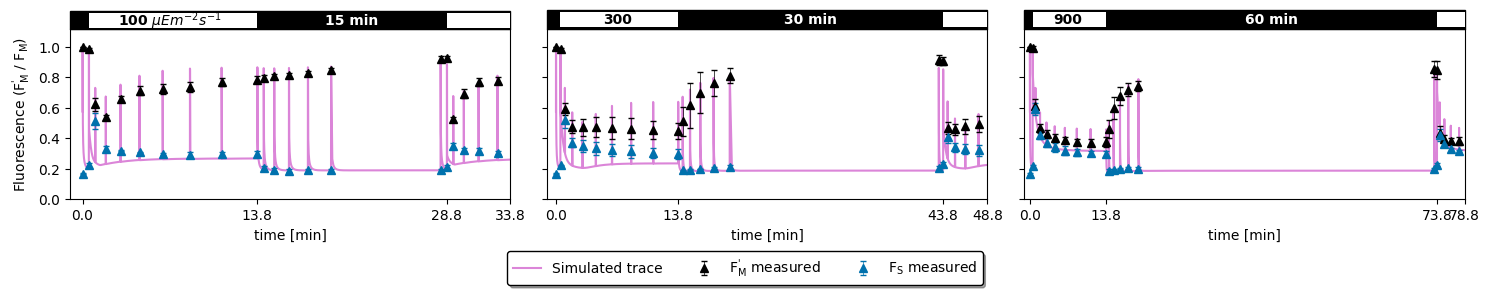

In [14]:
res = [
    {'sim': s1, 'protocol': pam_protocol1, 'light': 100, 'duration': 15},
    {'sim': s2, 'protocol': pam_protocol2, 'light': 300, 'duration': 30},
    {'sim': s3, 'protocol': pam_protocol3, 'light': 900, 'duration': 60},
]

fig, axs = plt.subplots(ncols=3, figsize=(15, 3), sharey=True)

for i in range(len(axs)):
    ax = axs[i]
    c = res[i]['sim'].get_full_results()
    pam_protocol = res[i]['protocol']
    exp_data = fig4_data[i]
    
    pam_ptrc_cleaned = pam_protocol[pam_protocol['pfd'] != 5000]
    pam_ptrc_peaks = pam_protocol[pam_protocol['pfd'] == 5000]
    peaks_times = pd.Series(pam_ptrc_peaks.index).apply(lambda x: x.total_seconds())

    ax.plot(c["Fluo"] / max(c["Fluo"]), color="#db85d8", label="Simulated trace")
    ax.errorbar(peaks_times, exp_data['Fm_rel_mean'][:-1], yerr=exp_data['Fm_rel_std'][:-1], marker="^", color="black", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_M^'}$ measured")
    ax.errorbar(peaks_times, exp_data['Ft_rel_mean'][:-1], yerr=exp_data['Ft_rel_std'][:-1], marker="^", color="#0071ad", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_S}$ measured")
    
    ax.set_xlim(-60, c.index[-1])
    ax.set_ylim(0, 1.11 * (exp_data['Fm_rel_mean'].max() + exp_data['Fm_rel_std'].iloc[exp_data['Fm_rel_mean'].idxmax()]))

    t0 = pd.Timedelta(seconds=-60)
    background_box_height = 0.12
    border_width = 0.01
    
    box = ax.add_patch(Rectangle(
            (t0.total_seconds(), ax.get_ylim()[-1]),
            width=pam_ptrc_cleaned['pfd'].index[-1].total_seconds() + 60,
            height=background_box_height,
            facecolor = 'black',
            edgecolor = 'black',
            lw = 1,
            clip_on=False
        ))

    timechanges = [['black', 0]]
    
    for t_end, val in pam_ptrc_cleaned['pfd'].items():
        t_end = cast(pd.Timedelta, t_end)
        if val == 0:
            color = 'black'
        else:
            color = 'white'
        ax.add_patch(Rectangle(
            (t0.total_seconds(), ax.get_ylim()[-1] + 0.01),
            width=t_end.total_seconds() - t0.total_seconds(),
            height=background_box_height - border_width * 2,
            facecolor = color,
            clip_on=False
        ))
        
        if timechanges[-1][0] != color:
            timechanges.append([color, t0.total_seconds()])

        t0 = t_end  # type: ignore
        
    timechanges.append(['white', c.index[-1]])
    timechanges.pop(1)
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/60:.1f}"))
    ax.set_xticks([i[-1] for i in timechanges])
    ax.set_xlabel('time [min]')
    
    ycoord_text = box.xy[1] + box.get_height() / 2
    
    xcoord_light = timechanges[0][1] + (timechanges[1][1] - timechanges[0][1]) / 2
    light_text = f'{res[i]['light']}'
    if res[i]['light'] == 100:
        light_text += r' $\mu E m^{{-2}} s^{{-1}}$'
        
    xcoord_dark = timechanges[1][1] + (timechanges[2][1] - timechanges[1][1]) / 2
    
    ax.text(xcoord_light, ycoord_text, light_text, ha="center", va="center", weight='bold')
    ax.text(xcoord_dark, ycoord_text, f"{res[i]['duration']} min", ha="center", va="center", weight='bold', color="white")

axs[0].set(
    ylabel=r"Fluorescence ($\mathrm{F_M^'}$ / $\mathrm{F_M}$)",
)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, ncols=3, loc='lower center', shadow=True, framealpha=1, edgecolor='black')

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
plt.show()

## Figure 5

In [15]:
def simulate_pam_different_lights(
    LP_pfds: list = [100, 300, 900],
    species: str = 'Arabidopsis',
    phases = [30, 14*60 - 30, 16*60, 5*60]
):
    
    res = []
    
    for pfd in LP_pfds:
        cpfd_val = cpfd(species, pfd)

        s = Simulator(Matuszynska2016())
        
        for time, light in zip(it.accumulate(phases), [0, cpfd_val] * len(phases)):
            s.update_parameter('pfd', light)
            s.simulate(time)
        res.append({
            'sim': s,
            'protocol': [(time, light) for time, light in zip(phases, [0, cpfd_val] * len(phases))],
            'light': pfd
        })
        
    return res

In [16]:
fig5_sims = simulate_pam_different_lights()

In [25]:
fig5_pH_lu_steady = []
fig5_Q_steady = []
fig5_timepoints_steady = []

s = Simulator(Matuszynska2016())
for i in tqdm(range(0, 1000, 10), "Simulating Steady State"):
    s.update_parameter('pfd', cpfd('Arabidopsis', i))
    s.simulate_to_steady_state()
    fig5_timepoints_steady.append(i)
    fig5_pH_lu_steady.append(s.get_full_results()['pH_lu'].iloc[-1])
    fig5_Q_steady.append(s.get_full_results()['Q'].iloc[-1])

Simulating Steady State:   0%|          | 0/100 [00:00<?, ?it/s]

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]


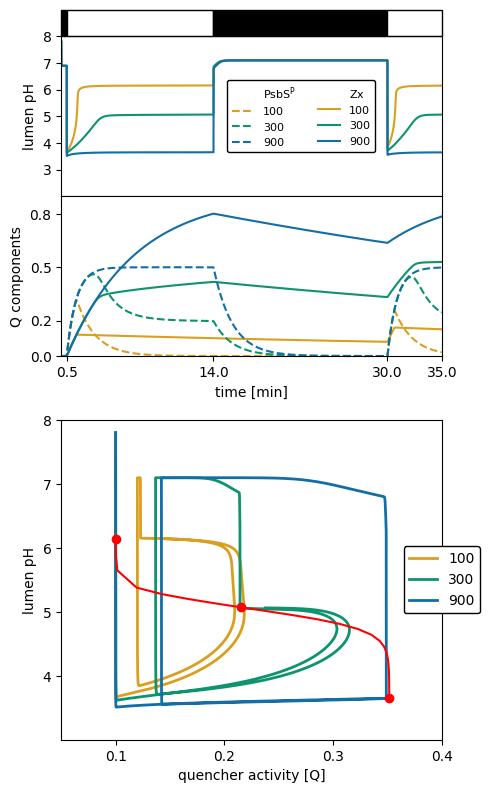

In [27]:
fig = plt.figure(figsize=(5, 8))

gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 0.4, 2], hspace=0)

ax_A_1 = fig.add_subplot(gs[0])
ax_A_1.set_ylim(2, 8)
ax_A_1.set_yticks([i for i in range(3,9)])
ax_A_1.set_ylabel("lumen pH")
ax_A_1.get_xaxis().set_visible(False)

ax_A_2 = fig.add_subplot(gs[1], sharex=ax_A_1)
ax_A_2.set_ylim(0, 0.9)
ax_A_2.set_yticks([0, 0.2, 0.5, 0.8])
ax_A_2.set_ylabel("Q components")
ax_A_2.set_xlim(0, fig5_sims[0]['sim'].get_full_results().index[-1])
ax_A_2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/60:.1f}"))
ax_A_2.set_xticks(list(it.accumulate([time for time, light in fig5_sims[0]['protocol']])))
ax_A_2.set_xlabel('time [min]')

ax_B = fig.add_subplot(gs[3])
ax_B.set_ylim(3, 8)
ax_B.set_yticks([i for i in range(4,9)])
ax_B.set_ylabel("lumen pH")
ax_B.set_xlim(0.05, 0.4)
ax_B.set_xticks([0.1, 0.2, 0.3, 0.4])
ax_B.set_xlabel("quencher activity [Q]")

print(fig5_timepoints_steady)

ax_B.plot(fig5_Q_steady, fig5_pH_lu_steady, color="#fb0102", zorder=9)

for i in [100, 300, 900]:
    ax_B.scatter(fig5_Q_steady[fig5_timepoints_steady.index(i)], fig5_pH_lu_steady[fig5_timepoints_steady.index(i)], color="#fb0102", zorder=10)

colors = [
    "#d99f21",
    "#0d936e",
    "#136ea6"
]

symbols = [
    'x',
    "o",
    "s"
]

for sim in fig5_sims:
    res = sim['sim'].get_full_results()
    light = sim['light']
    color = colors[fig5_sims.index(sim)]
    symbol = symbols[fig5_sims.index(sim)]
    
    for ax in [ax_A_1, ax_A_2]:
        ax.plot(res["pH_lu"], color=color)
        ax.plot(res["PsbSP"], color=color, linestyle='--', label=light)
        ax.plot(res["Zx"], color=color, label=light)
        
    ax_B.plot(res["Q"], res["pH_lu"], color=color, markersize=2, lw=2, label=light)

prior = 0
for time, light in fig5_sims[0]['protocol']:
    if light > 0:
        box_color = 'white'
    else:
        box_color = 'black'
    
    ax_A_1.add_patch(Rectangle(
            (prior, ax_A_1.get_ylim()[-1]),
            width=time,
            height=1,
            facecolor = box_color,
            edgecolor = 'black',
            clip_on=False
        ))
    prior += time

handles_labels = ax_A_1.get_legend_handles_labels()

handles_col1 = [Line2D([], [], color="none")]
handles_col2 = [Line2D([], [], color="none")]

labels_col1 = [r"$\mathrm{PsbS^P}$"]
labels_col2 = [r"$\mathrm{Zx}$"]

for i in range(len(handles_labels[0])):
    if i % 2 == 0:
        handles_col1.append(handles_labels[0][i])
        labels_col1.append(handles_labels[1][i])
    else:
        handles_col2.append(handles_labels[0][i])
        labels_col2.append(handles_labels[1][i])

ax_A_1.legend(list(it.chain(handles_col1, handles_col2)), list(it.chain(labels_col1, labels_col2)), ncols=2, prop={"size": 8}, framealpha=1, edgecolor="black", loc='center', bbox_to_anchor=(0.63,0.5))

ax_B.legend(loc='center', bbox_to_anchor=(1,0.5), edgecolor='black', framealpha=1)

plt.tight_layout()
plt.show()

In [ ]:
y = [0,2,3, 4, 4, 5]
x = ['a', 'b']

print(pH_lu_steady)

[1000.0    6.89691
Name: pH_lu, dtype: float64, 1000.0       6.896910
1000000.0    6.491652
Name: pH_lu, dtype: float64, 1000.0       6.896910
1000000.0    6.491652
1000000.0    6.419776
Name: pH_lu, dtype: float64, 1000.0       6.896910
1000000.0    6.491652
1000000.0    6.419776
1000000.0    6.374064
Name: pH_lu, dtype: float64, 1000.0       6.896910
1000000.0    6.491652
1000000.0    6.419776
1000000.0    6.374064
1000000.0    6.338578
Name: pH_lu, dtype: float64, 1000.0       6.896910
1000000.0    6.491652
1000000.0    6.419776
1000000.0    6.374064
1000000.0    6.338578
1000000.0    6.308204
Name: pH_lu, dtype: float64, 1000.0       6.896910
1000000.0    6.491652
1000000.0    6.419776
1000000.0    6.374064
1000000.0    6.338578
1000000.0    6.308204
1000000.0    6.280524
Name: pH_lu, dtype: float64, 1000.0       6.896910
1000000.0    6.491652
1000000.0    6.419776
1000000.0    6.374064
1000000.0    6.338578
1000000.0    6.308204
1000000.0    6.280524
1000000.0    6.254070
Name: pH